In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from keras.applications import EfficientNetV2B0
from keras.applications.efficientnet_v2 import preprocess_input
import time

tf.config.optimizer.set_jit(True)

2024-04-25 17:36:25.815241: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-25 17:36:25.815265: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-25 17:36:25.816122: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Creating the dataset
### Loading data

In [2]:
train_dir = './temp/train/'
valid_dir = './temp/validation/'

def get_id_img(directory):
    res = {}
    for identity in os.listdir(directory):
        temp_dir = os.path.join(directory, identity)
        lst = []
        for img_path in os.listdir(temp_dir):
            lst.append(os.path.join(directory, identity, img_path))
        res[int(identity)] = lst
        
    return res

train_data = get_id_img(train_dir)
valid_data = get_id_img(valid_dir)

### Creating triplet dataset

In [3]:
def get_triplet_dataset(data):
    res = []
    cnt = 0
    num_classes = len(data)
    min_class = min(data.keys())
    for identity in data.keys():
        id_images = data[identity]
        for i in range(len(id_images) - 1):
            # Anchor image
            anchor_path = id_images[i]
            # Take an image with the same identity for positive sample
            positive_path = id_images[i + 1]
    
            # Take an image with different identity for negative sample
            addition = np.random.randint(1, num_classes)
            negative_id = (identity + addition) % num_classes + min_class
            neg_id_images = data[negative_id]
            negative_path = neg_id_images[i]
    
            res.append([anchor_path, positive_path, negative_path])

        cnt += 1
        print(f'\r{cnt:>5} out of {len(data.keys()):>5}', end='')
    print()
    return res

print('Preparting train triplet dataset')
train_triplet = get_triplet_dataset(train_data)
print('Preparing validation triplet dataset')
valid_triplet = get_triplet_dataset(valid_data)

Preparting train triplet dataset
 2000 out of  2000
Preparing validation triplet dataset
33333 out of 33333


## Create the pipeline

In [4]:
IMAGE_SIZE = (112, 112)
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 64
BUFFER_SIZE = 1000

def get_image(path):
    file = tf.io.read_file(path)
    img = tf.image.decode_png(file, channels=3)
    return img


def get_images(anchor_path, positive_path, negative_path):
    anchor = get_image(anchor_path)
    positive = get_image(positive_path)
    negative = get_image(negative_path)
    return anchor, positive, negative


def normalize(image):
    image = tf.cast(image, tf.float32)
    return preprocess_input(image)


def augment(image):
    image = tf.image.random_contrast(image, 0.9, 1.2)
    image = tf.image.random_brightness(image, 0.2)
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_saturation(image, 0.9, 1.2)
    image = tf.clip_by_value(image, 0, 255)
    return image


def get_training_set(inputs):
    anchor_path, positive_path, negative_path = inputs[0], inputs[1], inputs[2]
    
    # Getting images
    anchor, positive, negative = get_images(anchor_path, positive_path, negative_path)

    # Random jpeg quality is done on integer images
    anchor = tf.image.random_jpeg_quality(anchor, 50, 100)
    positive = tf.image.random_jpeg_quality(positive, 50, 100)
    negative = tf.image.random_jpeg_quality(negative, 50, 100)

    # Resize the images
    anchor = tf.image.resize(anchor, IMAGE_SIZE)
    positive = tf.image.resize(positive, IMAGE_SIZE)
    negative = tf.image.resize(negative, IMAGE_SIZE)

    # do augment
    anchor = augment(anchor)
    positive = augment(positive)
    negative = augment(negative)

    # normalize
    anchor = normalize(anchor)
    positive = normalize(positive)
    negative = normalize(negative)

    return anchor, positive, negative


def get_validation_set(inputs):
    anchor_path, positive_path, negative_path = inputs[0], inputs[1], inputs[2]
    
    # Getting imagestrain_triplet
    anchor, positive, negative = get_images(anchor_path, positive_path, negative_path)

    # Resize the images
    anchor = tf.image.resize(anchor, IMAGE_SIZE)
    positive = tf.image.resize(positive, IMAGE_SIZE)
    negative = tf.image.resize(negative, IMAGE_SIZE)

    # normalize
    anchor = normalize(anchor)
    positive = normalize(positive)
    negative = normalize(negative)

    return anchor, positive, negative


train_ds = tf.data.Dataset.from_tensor_slices(train_triplet)
train_ds = train_ds.map(get_training_set, num_parallel_calls=AUTOTUNE)
train_ds = train_ds.shuffle(buffer_size=BUFFER_SIZE)
train_ds = train_ds.batch(BATCH_SIZE, num_parallel_calls=AUTOTUNE)
train_ds = train_ds.prefetch(AUTOTUNE)

valid_ds = tf.data.Dataset.from_tensor_slices(valid_triplet)
valid_ds = valid_ds.map(get_validation_set, num_parallel_calls=AUTOTUNE)
valid_ds = valid_ds.batch(BATCH_SIZE, num_parallel_calls=AUTOTUNE)
valid_ds = valid_ds.prefetch(AUTOTUNE)

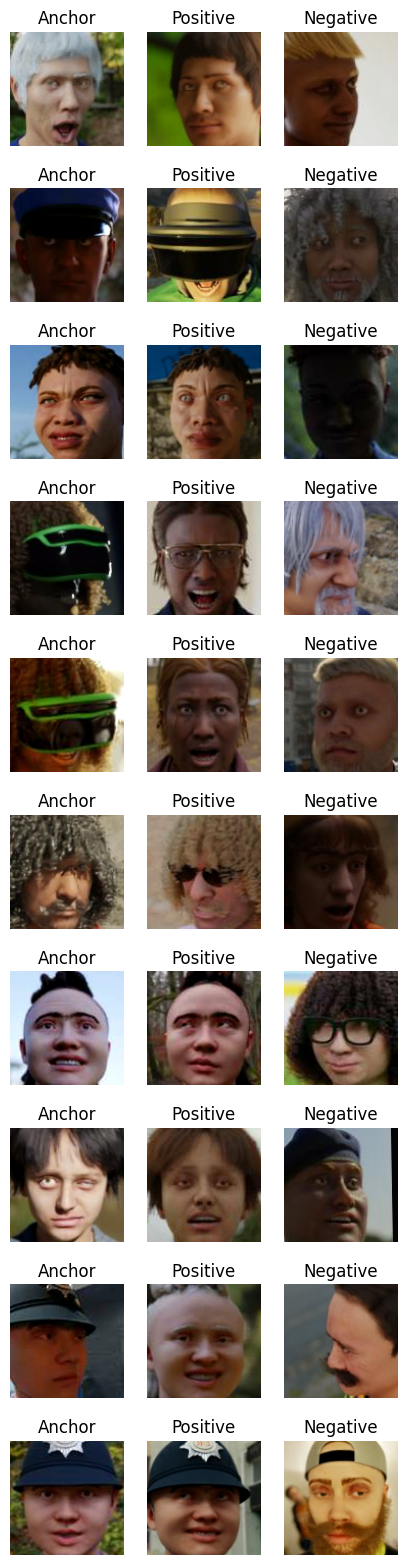

In [5]:
num_rows = 10
cnt = 0
plt.figure(figsize=(5, num_rows * 2))

for anc, pos, neg in train_ds.take(1):
    for i in range(num_rows):
        cnt += 1
        ax = plt.subplot(num_rows, 3, cnt)
        ax.imshow(anc[i] / 255.0)
        ax.axis('off')
        ax.set_title('Anchor')

        cnt += 1
        ax = plt.subplot(num_rows, 3, cnt)
        ax.imshow(pos[i] / 255.0)
        ax.axis('off')
        ax.set_title('Positive')

        cnt += 1
        ax = plt.subplot(num_rows, 3, cnt)
        ax.imshow(neg[i] / 255.0)
        ax.axis('off')
        ax.set_title('Negative')

## Create the model

In [6]:
from keras.layers import Dropout, Input, GlobalAveragePooling2D, Layer, Dense, Flatten
from keras.models import Model

In [7]:
class SiameseNetwork(Model):
    def __init__(self, units, dropout_rate=0.4):
        super(SiameseNetwork, self).__init__()
        
        self.base_model = EfficientNetV2B0(include_top=False)

        self.flatten = Flatten(name='flatten')
        self.dropout = Dropout(dropout_rate, name='dropout')
        self.encoder_output = Dense(units, activation='linear', name='encoder_output')

    def build(self, input_shape):
        inputs = Input(shape=input_shape)
        self.call(inputs)
        self.built = True

    def call(self, inputs, training=False):
        x = self.base_model(inputs, training=training)
        x = self.flatten(x)
        x = self.dropout(x)
        x = self.encoder_output(x)
        return x

In [8]:
siamese_net = SiameseNetwork(512)

siamese_net.base_model.trainable = True
for l in siamese_net.base_model.layers[:149]:
    l.trainable = False
    
siamese_net.build(input_shape=IMAGE_SIZE + (3,))
siamese_net.summary()

Model: "siamese_network"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 flatten (Flatten)           (None, 20480)             0         
                                                                 
 dropout (Dropout)           (None, 20480)             0         
                                                                 
 encoder_output (Dense)      (None, 512)               10486272  
                                                                 
Total params: 16405584 (62.58 MB)
Trainable params: 14972972 (57.12 MB)
Non-trainable params: 1432612 (5.46 MB)
_________________________________________________________________


## Compile the model

In [9]:
from keras.optimizers import Adam
from keras.metrics import Metric

### Triplet loss
Given three images to the neural-network to generate embeddings of that image we use triplet loss to optimize the network in a way to let the network recognize faces in the image.<br>
Each time ```anchor```, ```positive``` and ```negative``` images are given; ```anchor``` is the image with a face just like ```positive``` and ```negative``` is another face that is not like the other two. Using triplet loss we make the network choose vectors for ```anchor``` and ```positive``` in a way that their euclidean distance is minimized and a vector for ```negative``` in a way that its euclidean distance from ```anchor``` is maximized.

$$
\begin{align}
    d_{ap} &= \sqrt{\sum_{j}(\text{anchor}_j - \text{positive}_j)^2}\\
    d_{an} &= \sqrt{\sum_{j}(\text{anchor}_j - \text{negative}_j)^2}
\end{align}
$$

We wish to have $d_{ap} \le d_{an}$ in other words $d_{ap} - d_{an} \le 0$. However network might learn an embedding of all zeros, in that case the criteria is met and distances of $d_{ap}$ and $d_{ap}$ are $0$.<br>
Let's define a margin called ```alpha``` so that $d_{ap} - d_{an} \le -\alpha$, meaning that distance between anchor and positive is less than distance of anchor and negative by the amount of $\alpha$. 
$$
\begin{align}
    d_{ap} - d_{an} + \alpha \le 0
\end{align}
$$

In [10]:
def get_triplet_loss(alpha=1.0):
    def loss_func(anchor, positive, negative):
        d_ap = tf.reduce_sum(tf.square(anchor - positive), axis=-1)
        d_an = tf.reduce_sum(tf.square(anchor - negative), axis=-1)
        
        d_ap = tf.sqrt(d_ap)
        d_an = tf.sqrt(d_an)
        
        loss = tf.maximum(d_ap - d_an + alpha, 0)
        return tf.reduce_mean(loss)
    return loss_func


class TripletAccuracy(Metric):
    def __init__(self, alpha=1.0, name='triplet_metric', **kwargs):
        super(TripletAccuracy, self).__init__(name=name, **kwargs)

        self.count = self.add_weight(name='count',
                                   dtype='float32', 
                                   shape=(), 
                                   initializer='zeros')

        self.total = self.add_weight(name='total', 
                                   dtype='float32', 
                                   shape=(), 
                                   initializer='zeros')
        self.alpha = alpha


    def update_state(self, anchor, positive, negative):
        d_ap = tf.reduce_sum(tf.square(anchor - positive), axis=-1)
        d_an = tf.reduce_sum(tf.square(anchor - negative), axis=-1)
        
        d_ap = tf.sqrt(d_ap)
        d_an = tf.sqrt(d_an)
        
        d_ap = d_ap + self.alpha
        
        matches = tf.reduce_sum(tf.cast(d_ap <= d_an, tf.float32))
        self.count.assign_add(tf.reduce_sum(matches))
        self.total.assign_add(tf.cast(tf.shape(anchor)[0], dtype=tf.float32))


    def result(self):
        return self.count / self.total if self.total > 0.0 else 0.0


    def reset_states(self):
        self.total.assign(0.0)
        self.count.assign(0.0)
        

ALPHA = 1.0
triplet_loss = get_triplet_loss(ALPHA)
train_acc = TripletAccuracy(alpha=ALPHA)
valid_acc = TripletAccuracy(alpha=ALPHA)
optimizer = Adam()

In [11]:
@tf.function
def training_step(anchor, positive, negative):
    loss = 0
    with tf.GradientTape() as tape:
        a = siamese_net(anchor, training=True)
        p = siamese_net(positive, training=True)
        n = siamese_net(negative, training=True)
        loss = triplet_loss(a, p, n)
        train_acc.update_state(a, p, n)

    variables = siamese_net.trainable_variables
    grads = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(grads, variables))
    return loss

In [12]:
@tf.function
def validation_step(anchor, positive, negative):
    a = siamese_net(anchor, training=False)
    p = siamese_net(positive, training=False)
    n = siamese_net(negative, training=False)
    loss = triplet_loss(a, p, n)
    valid_acc.update_state(a, p, n)
    return loss

In [13]:
def train(epochs=10):
    train_loss_hist = []
    valid_loss_hist = []
    train_acc_hist = []
    valid_acc_hist = []

    for epoch in range(epochs):
        train_acc.reset_states()
        valid_acc.reset_states()
        start = time.time()
        train_mean_loss = 0
        valid_mean_loss = 0
        print(f'Epoch {epoch + 1:>3}')

        for step, (anchor, positive, negative) in enumerate(train_ds):
            loss = training_step(anchor, positive, negative)
            acc = train_acc.result()
            train_mean_loss = train_mean_loss + (1 / (step + 1)) * (loss - train_mean_loss)
            end = time.time()
            print(f'\r{int(end - start):>3} seconds | Step {step:>4}\tloss: {train_mean_loss:>4.4f}\taccuracy: {acc:>.3f}', end='')
        print()
        
        train_loss_hist.append(train_mean_loss)
        train_acc_hist.append(acc)

        for step, (anchor, positive, negative) in enumerate(valid_ds):
            loss = validation_step(anchor, positive, negative)
            acc = valid_acc.result()
            valid_mean_loss = valid_mean_loss + (1 / (step + 1)) * (loss - valid_mean_loss)

            end = time.time()
            print(f'\r{int(end - start):>3} seconds | Step {step:>4}\tloss: {valid_mean_loss:>4.4f}\taccuracy: {acc:>.3f}', end='')
        print()

        valid_loss_hist.append(valid_mean_loss)
        valid_acc_hist.append(acc)

    return {'epochs':list(range(0, epochs)), 
            'loss':train_loss_hist, 
            'acc':train_acc_hist, 
            'val_loss':valid_loss_hist, 
            'val_acc':valid_acc_hist}

In [14]:
history = train(epochs=5)

Epoch   1


2024-04-25 17:37:02.423928: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insiamese_network/efficientnetv2-b0/block2b_drop/dropout_2/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1714054031.900814   67979 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1714054047.969082   67979 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


280 seconds | Step 2217	loss: 0.4585	accuracy: 0.850

2024-04-25 17:41:29.499114: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insiamese_network/efficientnetv2-b0/block2b_drop/dropout_2/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


317 seconds | Step 2218	loss: 0.4584	accuracy: 0.850


W0000 00:00:1714054322.690528   67984 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


423 seconds | Step 2082	loss: 0.0834	accuracy: 0.971

W0000 00:00:1714054432.597508   67984 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


436 seconds | Step 2083	loss: 0.0834	accuracy: 0.971
Epoch   2
228 seconds | Step 2218	loss: 0.4062	accuracy: 0.899
330 seconds | Step 2083	loss: 0.0668	accuracy: 0.982
Epoch   3
231 seconds | Step 2218	loss: 0.3774	accuracy: 0.918
333 seconds | Step 2083	loss: 0.0680	accuracy: 0.984
Epoch   4
231 seconds | Step 2218	loss: 0.3425	accuracy: 0.934
333 seconds | Step 2083	loss: 0.0617	accuracy: 0.985
Epoch   5
231 seconds | Step 2218	loss: 0.2886	accuracy: 0.945
333 seconds | Step 2083	loss: 0.0597	accuracy: 0.987


## Fine-Tuning

In [15]:
FREEZE_UP_TO = 76

siamese_net.base_model.trainable = True

for i in range(FREEZE_UP_TO):
    siamese_net.base_model.layers[i].trainable = False

siamese_net.summary()

Model: "siamese_network"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 flatten (Flatten)           (None, 20480)             0         
                                                                 
 dropout (Dropout)           (None, 20480)             0         
                                                                 
 encoder_output (Dense)      (None, 512)               10486272  
                                                                 
Total params: 16405584 (62.58 MB)
Trainable params: 15920020 (60.73 MB)
Non-trainable params: 485564 (1.85 MB)
_________________________________________________________________


In [16]:
optimizer.learning_rate = 1e-4
fine_tune_history = train(epochs=5)

Epoch   1
231 seconds | Step 2218	loss: 0.1717	accuracy: 0.963
332 seconds | Step 2083	loss: 0.0459	accuracy: 0.990
Epoch   2
231 seconds | Step 2218	loss: 0.1335	accuracy: 0.971
335 seconds | Step 2083	loss: 0.0399	accuracy: 0.990
Epoch   3
231 seconds | Step 2218	loss: 0.1098	accuracy: 0.974
334 seconds | Step 2083	loss: 0.0352	accuracy: 0.991
Epoch   4
231 seconds | Step 2218	loss: 0.0916	accuracy: 0.976
333 seconds | Step 2083	loss: 0.0329	accuracy: 0.992
Epoch   5
231 seconds | Step 2218	loss: 0.0858	accuracy: 0.978
333 seconds | Step 2083	loss: 0.0338	accuracy: 0.991


## Evaluation

In [63]:
def plot(history, fine_tune_history, key, ax):
    epochs = history['epochs']
    train_key = history[key]
    val_key = history['val_' + key]

    fine_tune_epochs = [x + len(epochs) for x in fine_tune_history['epochs']]
    fine_train_key = fine_tune_history[key]
    fine_val_key = fine_tune_history['val_' + key]

    ax.plot(epochs + fine_tune_epochs, train_key + fine_train_key, label='train_' + key)
    ax.plot(epochs + fine_tune_epochs, val_key + fine_val_key, label='val_' + key)
    ax.axvline(x=fine_tune_epochs[0], c='red', label='fine_tune')
    ax.grid(c='#eee')
    ax.set_title(f'{key.capitalize()} per epoch')
    ax.set_xlabel('x')
    ax.set_ylabel(f'{key}')
    return ax

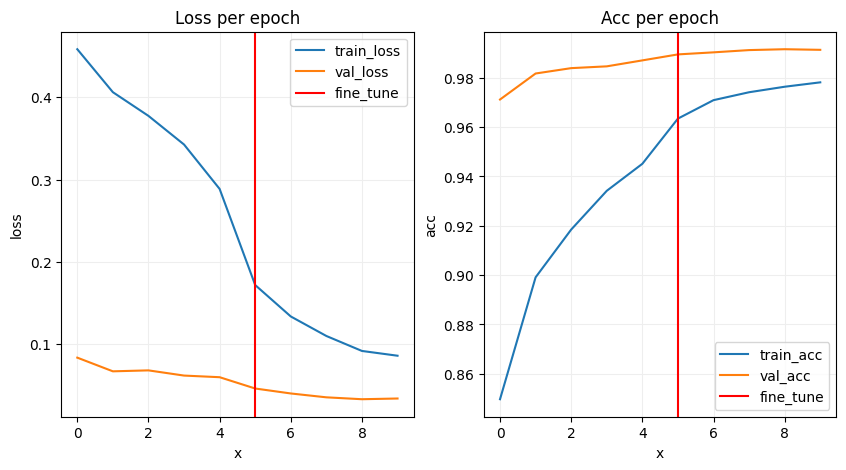

In [64]:
plt.figure(figsize=(10, 5))

ax = plt.subplot(1, 2, 1)
ax = plot(history, fine_tune_history, 'loss', ax)
ax.legend();

ax = plt.subplot(1, 2, 2)
ax = plot(history, fine_tune_history, 'acc', ax)
ax.legend();

## Save the model

In [81]:
class FaceRecognizer(Model):
    def __init__(self, siamese_net):
        super(FaceRecognizer, self).__init__()
        self.siamese_net = siamese_net


    def build(self, input_shape):
        anchor = Input(shape=input_shape)
        image = Input(shape=input_shape)
        self.call(anchor, image)
        self.built = True

    
    def call(self, anchor, image):
        anchor = preprocess_input(anchor)
        image = preprocess_input(image)
        anchor = self.siamese_net(anchor, training=False)
        image = self.siamese_net(image, training=False)
        similarity = tf.matmul(anchor, tf.transpose(image)) / (tf.linalg.norm(image) * tf.linalg.norm(anchor))
        return similarity
        

    def get_config(self):
        base_config = super(FaceRecognizer, self).get_config()
        config = {'siamese_net':self.siamese_net}
        return {**base_config, **config}

In [82]:
recognizer = FaceRecognizer(siamese_net)
recognizer.build(IMAGE_SIZE + (3,))
recognizer.summary()

Model: "face_recognizer_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 siamese_network (SiameseNe  (None, 512)               16405584  
 twork)                                                          
                                                                 
Total params: 16405584 (62.58 MB)
Trainable params: 15920020 (60.73 MB)
Non-trainable params: 485564 (1.85 MB)
_________________________________________________________________


In [83]:
anchor = cv2.imread('./me1.jpg')
anchor = cv2.cvtColor(anchor, cv2.COLOR_BGR2RGB)
anchor = cv2.resize(anchor, IMAGE_SIZE)

positive = cv2.imread('./me2.jpg')
positive = cv2.cvtColor(positive, cv2.COLOR_BGR2RGB)
positive = cv2.resize(positive, IMAGE_SIZE)

negative = cv2.imread('./not_me.jpg')
negative = cv2.cvtColor(negative, cv2.COLOR_BGR2RGB)
negative = cv2.resize(negative, IMAGE_SIZE)

In [89]:
print('ME:', recognizer(anchor, positive).numpy().flatten()[0])
print('NOT ME:', recognizer(anchor, negative).numpy().flatten()[0])

ME: 0.6042215
NOT ME: 0.34992296


In [92]:
siamese_net.save('./models/siamese_net_v1.tf')
recognizer.save('./models/recognizer_v1.tf')

INFO:tensorflow:Assets written to: ./models/siamese_net_v1.tf/assets


INFO:tensorflow:Assets written to: ./models/siamese_net_v1.tf/assets


INFO:tensorflow:Assets written to: ./models/recognizer_v1.tf/assets


INFO:tensorflow:Assets written to: ./models/recognizer_v1.tf/assets


#### Saving as tflite

In [93]:
converter = tf.lite.TFLiteConverter.from_saved_model('./models/recognizer_v1.tf/')
recognizer_tflite = converter.convert()

with open('./models/recognizer_tflite_v1.tflite', 'wb') as tflite_file:
    tflite_file.write(recognizer_tflite)

Summary on the non-converted ops:
---------------------------------
 * Accepted dialects: tfl, builtin, func
 * Non-Converted Ops: 191, Total Ops 745, % non-converted = 25.64 %
 * 191 ARITH ops

- arith.constant:  191 occurrences  (f32: 187, i32: 4)



  (f32: 30)
  (f32: 2)
  (f32: 150)
  (f32: 32)
  (f32: 1)
  (f32: 3)
  (f32: 142)
  (f32: 32)
  (f32: 149)

  (f32: 3)
  (f32: 2)
  (f32: 2)
  (f32: 2)
